In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import astropy.units as u
from astropy import time
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
from sunpy.coordinates import HeliographicStonyhurst,Helioprojective
from sunpy import coordinates
from astropy.coordinates import CartesianRepresentation, HeliocentricTrueEcliptic
from sunpy.net import Fido, attrs
from sunpy.map import Map
from aiapy.calibrate import register, update_pointing, correct_degradation
from aiapy.calibrate.util import get_correction_table
from dn2dem_pos import dn2dem_pos
from dem_class import Dem
from scipy import io as io

In [3]:
import netCDF4 as nc
#have to download goes data manually, only used to set the start time, end time and the axis markers for the impulsive phase start/end
fn = '/mnt/c/Users/Alasdair/Downloads/sci_xrsf-l2-avg1m_g17_d20201207_v2-1-0.nc'
ds = nc.Dataset(fn)
ttt=time.TimeDelta(ds['time'][:]+5,format='sec')
times=time.Time('2000-01-01 12:00:00')+ttt
#this timing stuff is to change from goes date format (seconds since 2000-01-01) to UTC, the +5 is for 5 leapseconds, adjust as necessary but with 1 minute cadence on the goes data it doesnt really matter if you get them right


In [5]:
#each of these collections of variables have a start time, t_on, a flare coordinate,x,y in either hp frame (default) or hgs by setting the reference frame to hgs (ref_f). Goes_imp is the start and end of the impulsive phase, just read off from the goes graph and adjust this way or that till you are happy. They are really just a visual indicator in the demogram and don't effect any calculations. Finally a name for pickle file.
# If you Just get the coordinates from hek, on disk will be stonyhurst and limb will be helioprojective
#-----------------------------------------------
# #event 1
# t_on = '2020-11-29 12:28:00'
# flare_pos=[-900,-345]
# ref_f='hp'
# pkname='1.pkl'
# goes_imp=[12*60+37,12*60+52]
# flare_pos=[-89,-23]
# ref_f='hgs'
#-----------------------------------------------
# event 2
# t_on = '2020-12-01 04:02:00'
# flare_pos=[-920,-360]
# goes_imp=[4*60+12,4*60+26]
# pkname='2.pkl'
# ref_f='hp'
#-----------------------------------------------
#event 3
# t_on = '2020-12-03 01:38:36'
# flare_pos=[37,-17]
# ref_f='hgs'
# goes_imp=[1*60+50,1*60+55]
# pkname='3.pkl'
#-----------------------------------------------
# #event 4
# t_on = '2020-12-05 00:12:00'
# flare_pos=[-27,-24]
# goes_imp=[22,37]
# ref_f='hgs'
# pkname='4.pkl'
# t_on = '2020-12-03 01:38:36'
# flare_pos=[576,-268]
# goes_imp=[1*60+50,1*60+55]
#-----------------------------------------------
#event 5
pkname='5.pkl'
t_on = '2020-12-07 15:30:00'
flare_pos=[115,-422]
ref_f='hp' 
goes_imp=[15*60+48,16*60+17] 
#-----------------------------------------------
#event 6
# pkname='6.pkl'
# t_on = '2020-12-14 14:08:00'
# flare_pos=[-50,-23]
# ref_f='hgs' 
# goes_imp=[14*60+20,14*60+35]
#-----------------------------------------------
#event 7
# pkname='7.pkl'
# t_on = '2021-01-20 12:23:00'
# flare_pos=[-52,-17]
# ref_f='hgs' 
# goes_imp=[12*60+32,12*60+52]
#-----------------------------------------------
#event 8
# pkname='8.pkl'
# t_on = '2021-02-27 17:40:00'
# flare_pos=[63,20]
# ref_f='hgs' 
# goes_imp=[17*60+56,18*60]
#-----------------------------------------------
#event 9
# pkname='9.pkl'
# t_on = '2021-02-28 06:34:00'
# flare_pos=[883,345]
# ref_f='hpc' 
# goes_imp=[6*60+42,6*60+46]
# -----------------------------------------------
#event 11 (1b)
# t_on = '2020-11-29 11:14:00'
# flare_pos=[-11,-20]
# ref_f='hgs'
# pkname='11.pkl'
# goes_imp=[11*60+28,11*60+37]






/home/awilson/anaconda3/lib/python3.8/site-packages/astropy/time/formats.py:1402: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  if np.any(val1.view((np.uint32, val1_str_len)) > 127):


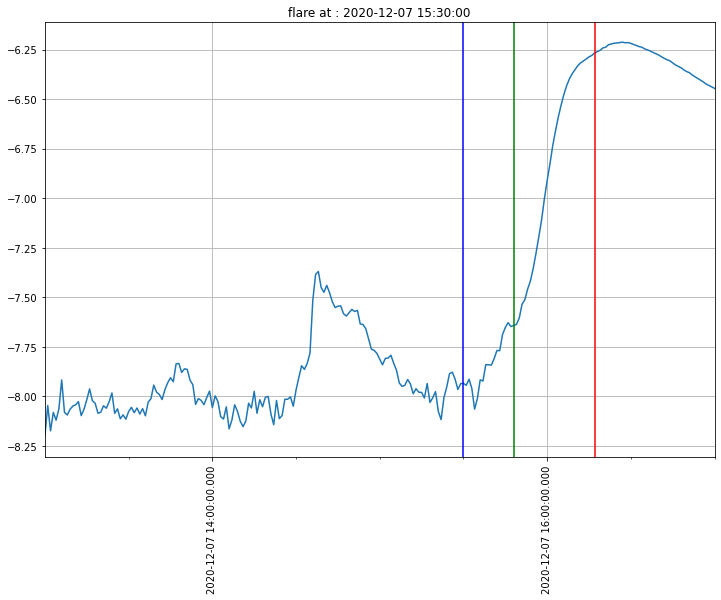

In [6]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
t_st=time.Time(t_on)
fig=plt.figure(figsize=[12,8])
plt.plot(ds['time'],np.log10(ds['xrsa_flux']))
plt.xticks(np.arange(12)*7200+ds['time'][0],times[0::120],rotation=90)
ax=plt.gca()
#we set our xlims manually
plt.xlim(ds['time'][13*60],ds['time'][17*60])
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.axvline(x=goes_imp[0]*60+ds['time'][0],color='green')
plt.axvline(x=goes_imp[1]*60+ds['time'][0],color='red')
plt.axvline(x=ds['time'][0]+t_st.ymdhms.hour*60*60+t_st.ymdhms.minute*60,color='blue')
plt.title('flare at : '+t_on)
plt.show()


In [7]:
n_time=28
nf=6
w_width=60

channels=[94,131,171,193,211,335]
# correction_table=get_correction_table('aia_V8_20171210_050627_response_table.txt') 
# correction_table=get_correction_table() 
# cal_ver=8
hp=Helioprojective(obstime=time.Time(t_on),observer='earth')
if ref_f=='hgs':
    hgs = HeliographicStonyhurst(obstime=time.Time(t_on))
    
    f_hgs=SkyCoord(flare_pos[0]*u.degree,flare_pos[1]*u.degree,frame=hgs,observer='earth')
    f_hp=f_hgs.transform_to(hp)
    flare_pos=[f_hp.Tx.value,f_hp.Ty.value]



def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [8]:
os.chdir('/mnt/c/Users/Alasdair/Documents/reginvpy')
#setup dem temps/bins/responses
tren=io.readsav('aia_trespv9_en.dat')
tresp_logt=tren.logt
tresp_calibrated=np.zeros([tresp_logt.shape[0],nf])
tresp_calibrated[:,:]=tren.tr.T
nt=32
t_space=0.05
t_min=5.6
logtemps=np.linspace(t_min,t_min+t_space*nt,num=nt+1)
temperatures=10**logtemps
logt_bin=np.zeros(nt)
for i in np.arange(nt):
    logt_bin[i]=(logtemps[i]+logtemps[i+1])/2
dem_t=[]


In [10]:
#download aia data
os.chdir('/mnt/h/data') #this actualyl does nothing, setup sunpy with data dir
for i in (np.arange(n_time-len(dem_t)))+len(dem_t):
    t=(time.Time(t_on)+time.TimeDelta(i*60*u.s))
    t2=t+time.TimeDelta(30*u.s)
    print(t.iso)
    query = Fido.search(
    attrs.Time(t.iso, t2.iso),
    attrs.Wavelength(channels[0]<<u.angstrom) | attrs.Wavelength(channels[1]<<u.angstrom) | attrs.Wavelength(channels[2]<<u.angstrom) | attrs.Wavelength(channels[3]<<u.angstrom) | attrs.Wavelength(channels[4]<<u.angstrom) | attrs.Wavelength(channels[5]<<u.angstrom), 
    attrs.vso.Sample(1<<u.minute),
    attrs.Instrument('AIA')
    )
    f= Fido.fetch(query)
    if len(f) < nf:
        dem_t.append(np.zeros([nx,ny,nt]))
        continue
    aia = Map(f)
    #trim the aia image to a smaller fov, centred on flare_pos
    for l in np.arange(nf):
        # aia[l]=update_pointing(aia[l])
        # aia[l]=register(aia[l])
        bl=SkyCoord((flare_pos[0]-w_width)*u.arcsec,(flare_pos[1]-w_width)*u.arcsec,frame=aia[l].coordinate_frame)
        tr=SkyCoord((flare_pos[0]+w_width)*u.arcsec,(flare_pos[1]+w_width)*u.arcsec,frame=aia[l].coordinate_frame)  
        aia[l] = aia[l].submap(bl,top_right=tr)
        print(l)
    aia_s= sorted(aia, key=lambda x: x.meta['wavelnth'])
    del(aia)
    nx=aia_s[0].data.shape[0]-2
    ny=aia_s[0].data.shape[0]-2
    data=np.zeros([nx,ny,nf])
    exp_time=np.zeros([6])
    for l in np.arange(6):
        exp_time[l]=aia_s[l].exposure_time.to(u.s).value
        data[:,:,l]=aia_s[l].data[:nx,:ny]

    npix=4096.**2/(nx*ny)
    edata=np.zeros([nx,ny,nf])
    gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
    dn2ph=gains*[94,131,171,193,211,335]/3397.0
    rdnse=1.15*np.sqrt(npix)/npix
    drknse=0.17
    qntnse=0.288819*np.sqrt(npix)/npix
    shotnoise=(dn2ph*data**0.5/dn2ph)
    serr_per=15
    esys=serr_per/100.0*data
    etemp=np.sqrt(rdnse**2.+drknse**2.+qntnse**2.+shotnoise**2)
    edata=np.sqrt(esys**2+etemp**2)
    for s in range(nf):
        data[:,:,s]=data[:,:,s]/exp_time[s]
        edata[:,:,s]=edata[:,:,s]/exp_time[s]
    dem_norm0=np.zeros([nx,ny,nt])
    norm_mean=6.4
    norm_std=0.3
    dem_norm=gaussian(logt_bin,norm_mean,norm_std)
    dem_norm0[:,:,:]=dem_norm[:]
    dem1=Dem()
    dem1.temperatures=temperatures
    dem1.data,dem1.edem,dem1.elogt,dem1.chisq,dem1.dn_reg=dn2dem_pos(data,edata,tresp_calibrated,tresp_logt,dem1.temperatures,max_iter=15,dem_norm0=dem_norm0)
    dem_t.append(dem1)

2020-12-07 15:38:00.000


OSError: Failed to read /home/awilson/sunpy/data/aia_lev1_94a_2020_12_07t15_38_11_12z_image_lev1.fits.

In [8]:
# import pickle
# import os
# os.chdir('/mnt/h/data')
# with open('2.pkl','rb') as f:
#     dem_t=pickle.load(f)
# nt=32

total_em=np.zeros([n_time,nt])
print(dem_t[0].data.shape)
x1=1
x2=150
y1=1 
y2=150
for i in np.arange(len(dem_t)):
    # print(dem_t[i].data.shape)
    total_em[i,:]=np.sum(np.sum(np.asarray(dem_t[i].data)[x1:x2,y1:y2,:],axis=0),axis=0)
tot_em_pf=np.sum(np.sum(np.asarray(dem_t[0].data)[x1:x2,y1:y2,:],axis=0),axis=0)

(199, 199, 32)


<ipython-input-9-adedeccce838>:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.flipud((total_em-tot_em_pf).T)),vmax=25,vmin=16,aspect='auto',extent=[0,n_time,logtemps[0],logtemps[31]])
<ipython-input-9-adedeccce838>:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.flipud((total_em-tot_em_pf).T)),vmax=25,vmin=16,aspect='auto',extent=[0,n_time,logtemps[0],logtemps[31]])


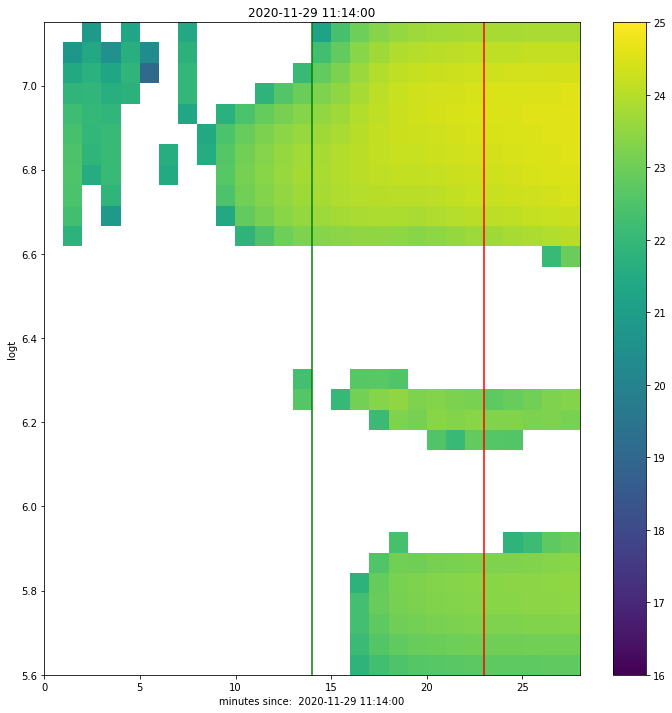

In [9]:
plt.figure(figsize=[12,12])
plt.imshow(np.log10(np.flipud((total_em-tot_em_pf).T)),vmax=25,vmin=16,aspect='auto',extent=[0,n_time,logtemps[0],logtemps[31]])
ax=plt.gca()
plt.colorbar()
plt.ylabel('logt')
plt.xlabel('minutes since:  '+t_on)
plt.title(t_on)
t_st=time.Time(t_on)
plt.axvline(x=goes_imp[0]-t_st.ymdhms.hour*60-t_st.ymdhms.minute,color='green')
plt.axvline(x=goes_imp[1]-t_st.ymdhms.hour*60-t_st.ymdhms.minute,color='r')

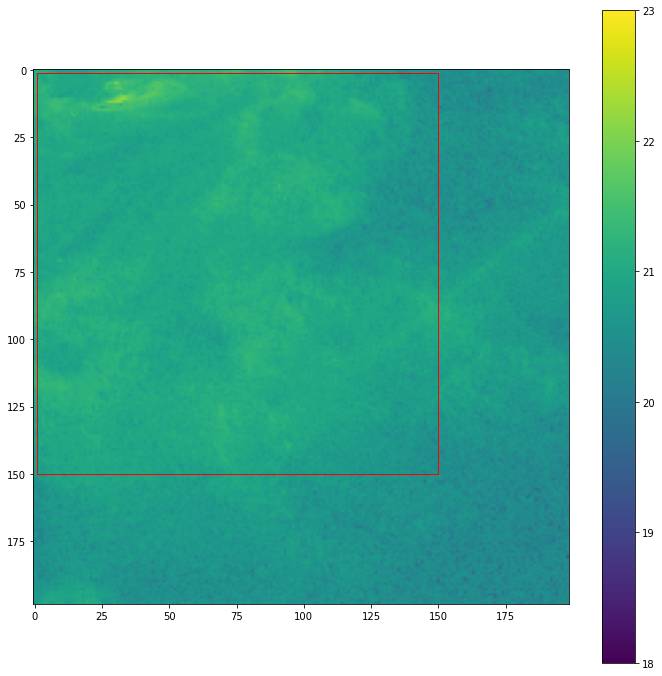

In [10]:
plt.figure(figsize=[12,12])
dem_hot=np.zeros([nx,ny,n_time])
for i in np.arange(n_time):     
    dem_hot[:,:,i]=np.sum(np.asarray(dem_t[i].data)[:,:,26:],axis=2)
hot_pf=np.sum(np.asarray(dem_t[0].data)[:,:,26:],axis=2)
t_bin=30
t=9
plt.imshow(np.flipud(np.log10(dem_hot[:,:,t])),vmax=23,vmin=18)
plt.colorbar()
ax=plt.gca()
rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

<Figure size 432x288 with 0 Axes>

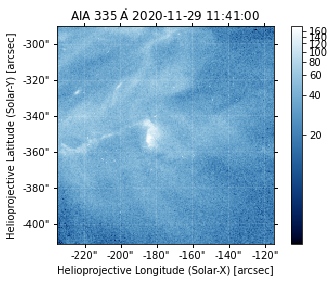

In [11]:
#have a look at aia
fig =plt.figure()
aia_s[5].peek()

In [12]:
#save the data
import pickle
import os
os.chdir('/mnt/h/data')
with open(pkname,'wb') as fs:
    pickle.dump(dem_t,fs)

In [13]:
len(dem_t)

28